In [27]:
import os
import IPython
import librosa as lr
import numpy as np
from datetime import datetime
from packaging import version
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from librosa import display
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Activation,Conv2DTranspose
import time
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.fft import fft, fftfreq

#LOG_DIR = f'{int(time.time())}'

path = 'C:/Users/erikv/Desktop/IP/samples/' #path where the samples are stored'''
dirs = os.listdir(path)

def rosaspec(sound, NFFT): #defined functions for extracting the spectogram of a sound wave'''
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)

def irosaspec(spec,NFFT): #defined function for extracting a soundwave from a spectogram'''
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]

autoencoder = tf.keras.models.load_model('autoencoder_v26')
encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')
visualizer = tf.keras.models.load_model('visualizer')
shortener = visualizer.get_layer('shortener')
reshaper = visualizer.get_layer('reshaper')
print ('done')

done


In [2]:
NFFT =  int(1022/8)
def selectionbatchtimbrename(name,timbre):
    batchsel = []
    for i in dirs:
        filename = os.path.splitext(os.path.basename(i))
        strin = str(filename[0])
        separated = strin.split('_')
        root = separated[2]
        rootsep = root.split('-')
        if int(rootsep[0]) == timbre:
            if separated[0] == str(name):
                batchsel.append(i)
    print('selected instrument: '+batchsel[1])
    print('samples: ',len(batchsel))
    return batchsel

def selectionbatchnotename(name,note):
    batchsel = []
    for i in dirs:
        filename = os.path.splitext(os.path.basename(i))
        strin = str(filename[0])
        separated = strin.split('_')
        root = separated[2]
        rootsep = root.split('-')
        if int(rootsep[1]) == note:
            if separated[0] == str(name):
                batchsel.append(i)
    print('selected instrument: '+batchsel[1])
    print('samples: ',len(batchsel))
    return batchsel

def selectionbatchnote(note):
    batchsel = []
    for i in dirs:
        filename = os.path.splitext(os.path.basename(i))
        strin = str(filename[0])
        separated = strin.split('_')
        root = separated[2]
        rootsep = root.split('-')
        if int(rootsep[1]) == note:
            batchsel.append(i)
    print('selected instrument: '+batchsel[1])
    print('samples: ',len(batchsel))
    return batchsel

In [32]:
batchsel = selectionbatchtimbrename("vocal",3)
probe = np.zeros([len(batchsel), 64, 64, 2]) #prepare a 0 array. The processes is a loop using the same 
                                               #procedure as explained before
for i in range(len(batchsel)):
    yoriginal,sroriginal = lr.load(path+batchsel[i],sr=2*8000) 
    yoriginal = yoriginal[0:int(len(yoriginal)/16)]
    #originalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    asignal = np.array([rosaspec(yoriginal,NFFT)])
    audio = asignal#/asignal.max()
    probe[i] = audio
print (batchsel)

def fftpl(audio,sr):
    n = len(audio)
    T = 1/sr
    yf = fft(audio)
    xf = fftfreq(n,T)[:n//2]
    x,y = xf,2.0/n * np.abs(yf[:n//2])
    return x,y


selected instrument: vocal_synthetic_003-022-100.wav
samples:  119
['vocal_synthetic_003-022-025.wav', 'vocal_synthetic_003-022-100.wav', 'vocal_synthetic_003-023-100.wav', 'vocal_synthetic_003-024-025.wav', 'vocal_synthetic_003-027-050.wav', 'vocal_synthetic_003-027-075.wav', 'vocal_synthetic_003-027-100.wav', 'vocal_synthetic_003-028-025.wav', 'vocal_synthetic_003-028-100.wav', 'vocal_synthetic_003-029-050.wav', 'vocal_synthetic_003-030-127.wav', 'vocal_synthetic_003-032-127.wav', 'vocal_synthetic_003-033-050.wav', 'vocal_synthetic_003-033-127.wav', 'vocal_synthetic_003-034-025.wav', 'vocal_synthetic_003-035-075.wav', 'vocal_synthetic_003-036-025.wav', 'vocal_synthetic_003-036-100.wav', 'vocal_synthetic_003-036-127.wav', 'vocal_synthetic_003-039-127.wav', 'vocal_synthetic_003-040-127.wav', 'vocal_synthetic_003-041-075.wav', 'vocal_synthetic_003-041-127.wav', 'vocal_synthetic_003-042-050.wav', 'vocal_synthetic_003-042-127.wav', 'vocal_synthetic_003-044-127.wav', 'vocal_synthetic_003-0

(119, 256)


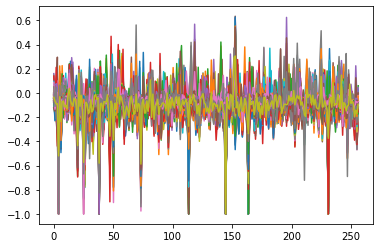

In [162]:
import matplotlib.pyplot as plt
vectors = np.zeros((len(batchsel),256))
for n in range(len(batchsel)):
    encoded_vector = encoder(np.array([probe[n]]))
    short = shortener(encoded_vector)
    shortened_vector = short/max(abs(short[0]))
    reshaped_vector = reshaper(shortened_vector)
    decoded_array = np.array(decoder(reshaped_vector)) #a sample file is runned through the autoencoder
    decoded_audio = irosaspec(decoded_array[0],NFFT)
    original = irosaspec(probe[n],NFFT)#this is just the sample file runned directly from the processed array NOT the autoenc.

    #lr.display.waveplot(y=original,sr=sroriginal)
    #lr.display.waveplot(y=decoded_audio,sr=sroriginal)
    #plt.show()
    plt.plot(np.linspace(0,256,256),shortened_vector[0])

    #IPython.display.display(IPython.display.Audio(original,rate = sroriginal))
    #IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal))
    vect = shortened_vector.numpy()
    vectors[n] = vect
    #print ('minimum location:',np.argmin(vect[0]))
    #print ('minimum value:', vect[0,163])
print(vectors.shape)

[0.19015714 0.10679277 0.08608653 0.07413655 0.05953511 0.04392223
 0.03157682 0.0297457  0.02567262 0.023651   0.01976222 0.01895261
 0.01755728 0.01518282 0.01293685 0.0117299  0.01103416 0.01036528
 0.00966467 0.00945517 0.00896467 0.00824039 0.00780403 0.00748518
 0.00738814 0.00711375 0.00662304 0.00612666 0.00582904 0.00571799
 0.00558689 0.00535606 0.00512629 0.00491604 0.00464463]
0.9048402517955292


(0.0, 256.0, -1.0, 1.0)

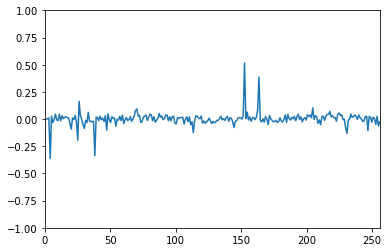

In [169]:
pca = PCA(n_components = 35)
pca.fit(vectors)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_)[-1])
P = pca.components_ 
plt.plot (np.linspace(0,256,256),P[1])
plt.axis([0,256,-1,1])
#plt.plot(np.linspace(0,256,256),vectors[20])


In [35]:
pca.score_samples(vectors)

array([358.62271329, 359.03929084, 376.52907128, 377.39858434,
       362.61546403, 366.84721929, 376.90024984, 376.39211947,
       382.36589778, 363.82117929, 366.09014706, 365.32378435,
       350.98828222, 365.75025558, 375.55391958, 376.06221566,
       363.88730559, 378.21070422, 378.54211052, 381.9589205 ,
       379.61802041, 380.97805214, 383.25874744, 376.12643254,
       377.58937413, 361.75379781, 362.81138543, 369.12155454,
       366.83309758, 363.00361319, 378.26035003, 378.23533704,
       368.36993942, 369.84537737, 345.94523961, 356.49888577,
       360.22845878, 371.25231804, 368.37090128, 369.51758374,
       363.63939224, 356.89817371, 359.81432277, 368.20992985,
       370.05117507, 370.44711459, 378.30670626, 379.12347443,
       360.92548528, 366.20064675])

selected instrument: bass_synthetic_033-100-127.wav
samples:  25
['bass_synthetic_033-100-100.wav', 'bass_synthetic_033-100-127.wav', 'bass_synthetic_034-100-025.wav', 'bass_synthetic_068-100-050.wav', 'bass_synthetic_134-100-025.wav', 'bass_synthetic_134-100-100.wav', 'bass_synthetic_135-100-025.wav', 'brass_acoustic_046-100-025.wav', 'flute_synthetic_000-100-025.wav', 'flute_synthetic_000-100-050.wav', 'flute_synthetic_000-100-075.wav', 'guitar_acoustic_014-100-127.wav', 'guitar_acoustic_015-100-075.wav', 'guitar_acoustic_021-100-050.wav', 'guitar_acoustic_021-100-075.wav', 'guitar_acoustic_021-100-100.wav', 'keyboard_acoustic_004-100-050.wav', 'keyboard_electronic_001-100-100.wav', 'keyboard_electronic_098-100-075.wav', 'keyboard_synthetic_000-100-075.wav', 'keyboard_synthetic_000-100-100.wav', 'mallet_acoustic_047-100-127.wav', 'mallet_acoustic_062-100-127.wav', 'vocal_synthetic_003-100-050.wav', 'vocal_synthetic_003-100-127.wav']
(25, 256)


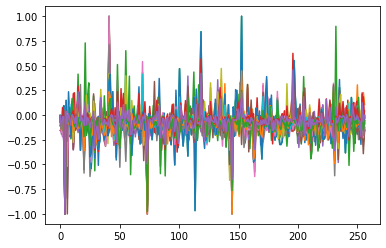

In [40]:
batchsel = selectionbatchnote(100)
probe = np.zeros([len(batchsel), 64, 64, 2]) #prepare a 0 array. The processes is a loop using the same 
                                               #procedure as explained before
for i in range(len(batchsel)):
    yoriginal,sroriginal = lr.load(path+batchsel[i],sr=2*8000) 
    yoriginal = yoriginal[0:int(len(yoriginal)/16)]
    #originalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    asignal = np.array([rosaspec(yoriginal,NFFT)])
    audio = asignal#/asignal.max()
    probe[i] = audio
print (batchsel)

import matplotlib.pyplot as plt
vectors = np.zeros((len(batchsel),256))
for n in range(len(batchsel)):
    encoded_vector = encoder(np.array([probe[n]]))
    short = shortener(encoded_vector)
    shortened_vector = short/max(abs(short[0]))
    reshaped_vector = reshaper(shortened_vector)
    decoded_array = np.array(decoder(reshaped_vector)) #a sample file is runned through the autoencoder
    decoded_audio = irosaspec(decoded_array[0],NFFT)
    original = irosaspec(probe[n],NFFT)#this is just the sample file runned directly from the processed array NOT the autoenc.

    #lr.display.waveplot(y=original,sr=sroriginal)
    #lr.display.waveplot(y=decoded_audio,sr=sroriginal)
    #plt.show()
    plt.plot(np.linspace(0,256,256),shortened_vector[0])


    #IPython.display.display(IPython.display.Audio(original,rate = sroriginal))
    #IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal))
    vect = shortened_vector.numpy()
    vectors[n] = vect
    #print ('minimum location:',np.argmin(vect[0]))
    #print ('minimum value:', vect[0,163])
print(vectors.shape)



[0.2969416  0.1994101  0.11382257 0.08443169 0.06432134 0.04513665
 0.03335482 0.03045136 0.02386868 0.01911807 0.01697165 0.0144001
 0.01284678 0.01067373 0.00929143 0.00711522 0.00625011 0.00436725
 0.00316038 0.00157581 0.00148721 0.00100341]
0.9999999756100093


(0.0, 256.0, -1.0, 1.0)

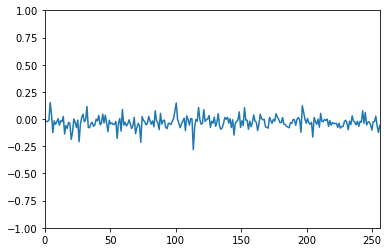

In [22]:
pca = PCA(n_components = 22)
pca.fit(vectors)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_)[-1])
P = pca.components_ 
plt.plot (np.linspace(0,256,256),P[1])
plt.axis([0,256,-1,1])
#plt.plot(np.linspace(0,256,256),vectors[20])
